## Demo for image noise estimation (processed, signal-dependent and AWGN)

In [1]:
import numpy as np
from imnest_ivhc import imnest_ivhc
import skimage.io
import skimage.filters
import matplotlib.pyplot as plt

##  Estimation of AWGN

In [2]:
np.random.seed(0)
img = skimage.io.imread('./img/kodim04.png')

print('----- Synthetic AWGN -----')

for sigma_a in [5, 10, 15]:
    noise = sigma_a*np.random.randn(img.shape[0], img.shape[1])
    noise_std = np.std(noise)
    im_n = np.float32(img[:,:,0]) + np.float32(noise)
    [est_sigma_p, est_sigma_o, nlf] = imnest_ivhc(im_n, 0)
    est_error = np.abs(noise_std-est_sigma_p)
    print('------------------------')
    print('sigma_a = %2.3f, sigma_n =  %2.3f '%(sigma_a, noise_std))
    print('Noise std estimation error: %2.3f %%'%(100*est_error/noise_std))
    print('------------------------')

----- Synthetic AWGN -----
------------------------
sigma_a = 5.000, sigma_n =  4.994 
Noise std estimation error: 0.692 %
------------------------
------------------------
sigma_a = 10.000, sigma_n =  10.002 
Noise std estimation error: 0.552 %
------------------------
------------------------
sigma_a = 15.000, sigma_n =  15.006 
Noise std estimation error: 1.103 %
------------------------


## Estimation of frequency-dependent (processed) noise

In [3]:
# to simulate processed noise
def bilateral_flt(img_in, var_n, radius, sigma_s):

    img_or = img_in
    i_out = 0
    P = 0

    (rows, cols) = img_in.shape
    img_in = np.pad(img_in, (radius, radius),'reflect')
    ar = np.arange(-radius, radius+1, 1)

    [dx, dy] = np.meshgrid(ar, ar)
    h = np.exp(- (dx**2 + dy**2) / (2 * sigma_s**2))

    for y in ar:
        for x in ar:
      
            X = img_in[radius+y:rows+radius+y,radius+x:cols+radius+x]
            delta =  X  - img_or
            pN =h[y+radius,x+radius]*np.exp(-delta*delta/(2*var_n))
            i_out = i_out + pN*X
            P = P+ pN

    i_out = i_out/P

    return i_out

In [4]:
print('----- Anisotropic spatially correlated noise -----')
np.random.seed(0)
img = skimage.io.imread('./img/peppers.png')

for sigma_a in [10, 15]:
    for scale in [0.5, 1, 2]:
        noise = sigma_a*np.random.randn(img.shape[0], img.shape[1])
        noise = bilateral_flt(noise, sigma_a*sigma_a*scale, 1, 1)
        noise_std = np.std(noise)
        im_n = np.float32(img[:,:,0]) + np.float32(noise)
        [est_sigma_p, est_sigma_o, nlf] = imnest_ivhc(im_n, 0)
        est_error = np.abs(noise_std-est_sigma_p)
        est_error = abs(noise_std-est_sigma_p)
        est_gamma = est_sigma_o/est_sigma_p
        print('------------------------')
        print('sigma_BL = %2.3f, sigma_a = %2.3f, sigma_n = %2.3f'%(sigma_a*scale,sigma_a,noise_std))
        print('Noise std estimation error: %2.3f'%(est_error))
        print('Estimated processing degree: %2.3f'%(est_gamma))
        print('------------------------')
        

print('')
print('')
print('----- Isotropic spatially correlated noise -----')
np.random.seed(0)
img = skimage.io.imread('./img/peppers.png')

for sigma_a in [10, 15]:
    for sigma_GB in [0.45, 0.5, 0.55]:
        noise = sigma_a*np.random.randn(img.shape[0], img.shape[1])
        noise = skimage.filters.gaussian(noise, sigma=sigma_GB, mode='reflect')
        noise_std = np.std(noise)
        im_n = np.float32(img[:,:,0]) + np.float32(noise)
        [est_sigma_p, est_sigma_o, nlf] = imnest_ivhc(im_n, 0)
        est_error = np.abs(noise_std-est_sigma_p)
        est_error = abs(noise_std-est_sigma_p)
        est_gamma = est_sigma_o/est_sigma_p
        print('------------------------')
        print('sigma_GB = %2.3f, sigma_a = %2.3f, sigma_n = %2.3f'%(sigma_GB,sigma_a,noise_std))
        print('Noise std estimation error: %2.3f'%(est_error))
        print('Estimated processing degree: %2.3f'%(est_gamma))
        print('------------------------')

----- Anisotropic spatially correlated noise -----
------------------------
sigma_BL = 5.000, sigma_a = 10.000, sigma_n = 8.519
Noise std estimation error: 0.337
Estimated processing degree: 1.219
------------------------
------------------------
sigma_BL = 10.000, sigma_a = 10.000, sigma_n = 7.344
Noise std estimation error: 0.352
Estimated processing degree: 1.299
------------------------
------------------------
sigma_BL = 20.000, sigma_a = 10.000, sigma_n = 5.935
Noise std estimation error: 0.003
Estimated processing degree: 1.463
------------------------
------------------------
sigma_BL = 7.500, sigma_a = 15.000, sigma_n = 12.828
Noise std estimation error: 0.430
Estimated processing degree: 1.288
------------------------
------------------------
sigma_BL = 15.000, sigma_a = 15.000, sigma_n = 10.966
Noise std estimation error: 0.535
Estimated processing degree: 1.461
------------------------
------------------------
sigma_BL = 30.000, sigma_a = 15.000, sigma_n = 8.876
Noise std e

## Signal-dependent (mixed Possionian-Gaussian) image noise

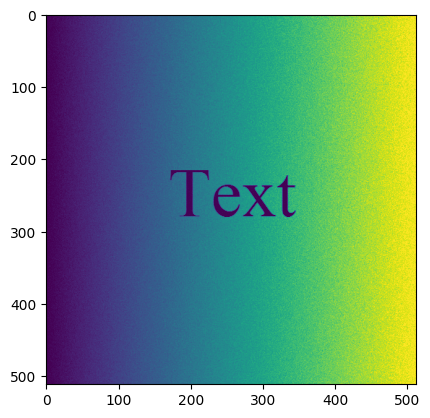

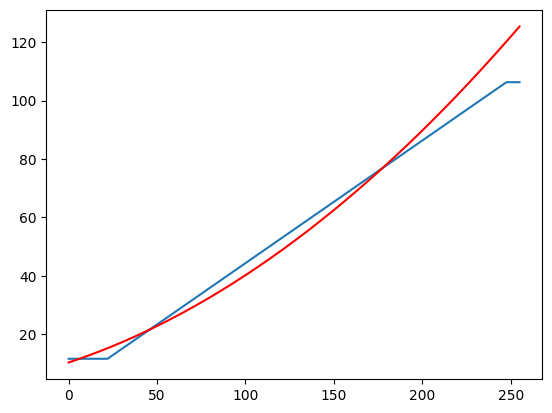

RMSE of estimated noise variance: 5.405
Max error of estimated noise variance: 19.098
RMSE of estimated standard deviation: 0.307
Max error of estimated standard deviation: 0.888


In [6]:
np.random.seed(0)
img = skimage.io.imread('./img/sample1.png')
# generate signal-dependent noise
sigma_noise = 8
nlf_sqrt = sigma_noise*(.4+np.arange(0, 256)/255.0)
nlf = nlf_sqrt**2
noise = np.random.randn(img.shape[0], img.shape[1])*nlf_sqrt[np.int32(img[:,:,0])]
# generate noisy image
im_n = np.float32(img[:,:,0]) + np.float32(noise)

[est_sigma_p, est_sigma_o, est_var_nlf] = imnest_ivhc(im_n)

im_n[im_n<0] = 0
im_n[im_n>255] = 255
plt.imshow(np.uint8(im_n))
plt.show()

plt.plot(est_var_nlf)
plt.plot(nlf,'r')
plt.show()

rmse_var = np.sqrt(np.mean((est_var_nlf-nlf)**2))
maxe_var = np.max(np.abs(est_var_nlf-nlf))

print('RMSE of estimated noise variance: %2.3f'%(rmse_var))
print('Max error of estimated noise variance: %2.3f'%(maxe_var))


rmse_std = np.sqrt(np.mean((np.sqrt(est_var_nlf)-np.sqrt(nlf))**2))
maxe_std = np.max(np.abs(np.sqrt(est_var_nlf)-np.sqrt(nlf)))

print('RMSE of estimated standard deviation: %2.3f'%(rmse_std))
print('Max error of estimated standard deviation: %2.3f'%(maxe_std))